
# <center>`Анализ библиотеки`<a style='color:red'> facenet-pytorch</a>
___

Ссылки на `документацию`:

| Описание| Ссылка|
| - | -  |
|Документация facenet-pytorch |[*Pypi facenet-pytorch*](https://pypi.org/project/facenet-pytorch/)|
|GitHub  facenet-pytorch| [*GitHub facenet-pytorch*](https://github.com/timesler/facenet-pytorch)|
|Датасет VGGFace | [*VGGFace dataset*](https://github.com/ox-vgg/vgg_face2)|
|Датасет CASIA-WebFace | [*CASIA-WebFace dataset*](https://www.kaggle.com/datasets/debarghamitraroy/casia-webface)|


___
<a id=100>Содержание</a>
- [Краткое описание библиотеки](#1)
- [Обзор основных функций библиотеки](#2)
    - [Детектирование и распознавание лиц](#3)
    - [Отслеживание лиц на видео](#4)
- [Анализ работы библиотеки](#5)
    - [Датасет](#6)
    - [Анализ функций](#7)
    - [Сохранение промежуточных данных](#8)
    - [Датафрейм с результатами анализа](#9)

___
## <center><a id=1 >Краткое описание библиотеки</a>

В библиотеке использованы решения:
| Задача| Решение|
| :-: | :-:  |
| Детектирование лиц | `MTCNN` |
| Распознавание лиц | `Inception Resnet (V1)` |


Заявленная точность распознавания:
| Предобученные веса| LFW accuracy|
| :-: | :-:  |
|CASIA-WebFace |`0.9905` |
|VGGFace2 |`0.9965` |


Facenet-pytorch - высокоуровневая библиотека для решения задач распознавания лиц на изображениях.
Для распознавания лиц используются  нейронная сеть **Inception Resnet (V1)** с предобученными весами на датасетах **VGGFace2** и **CASIA-Webface**.

**ResNet** (Residual Neural Network) - это архитектура глубоких нейронных сетей, которая была разработана для решения проблемы затухания градиентов. Inception ResNet v1 - одна из первых версий архитектуры ResNet, которая была представлена в 2015 году.

Для детектирования лиц используется предобученная нейронная сеть **MTCNN**.

**MTCNN** (Multi-Task Cascaded Convolutional Neural Network) - это глубокая нейронная сеть, которая была разработана для решения задачи детектирования лиц. MTCNN состоит из трех основных последовательно работающих нейронных сетей:
- **P-Net** извлекает признаки и предсказывает координаты рамок и вероятности наличия лица в каждой рамке.
- **R-Net** извлекает признаки и уточняет координаты рамок и вероятности наличия лица в каждой рамке.
- **O-Net** предсказывает координаты глаз, носа, рта.

___
## <center><a id=2 >Обзор основных функций библиотеки</a>

___
### <center><a id=3 >Детектирование и распознавание лиц</a>
- Создание моделей `детектирования` и `распознавания`
    - `pretrained`: предобученные веса на определенных датасетах (160x160 px): 
        - 'vggface2' 
        - 'casia-webface'

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch


mtcnn = MTCNN()
resnet = InceptionResnetV1(pretrained='vggface2').eval()

___
- Загрузка изображений

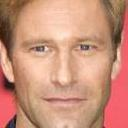

In [2]:
from PIL import Image
import os

db_path = 'data/Facescrub/Aaron_Eckhart/'
img_names = list(os.walk(db_path))[0][2]
img_path = db_path + img_names[7]

img = Image.open(img_path)
img

___
- Изображение $\rightarrow$ `tensor` детектированного лица
- tensor $\rightarrow$ `embedding`


In [4]:
img_cropped = mtcnn(img)

img_embedding = resnet(img_cropped.unsqueeze(0))

#  Для задач классификации
resnet.classify = True 
img_probs = resnet(img_cropped.unsqueeze(0))
print(f'Embedding:{img_embedding}')

Embedding:tensor([[-0.6337,  4.7145,  1.2781,  ...,  3.0937, -0.9101,  2.6665]],
       grad_fn=<AddmmBackward0>)


___
### <center><a id=4 >Отслеживание лиц на видео</a>

- `Создание` модели MTCNN

In [5]:
from facenet_pytorch import MTCNN
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

print('Running on device: {}'.format(device))

Running on device: cpu


- `Загрузка видео` 
- `Извлечение кадров`

In [7]:
import mmcv
from IPython import display
import cv2


db_path = 'data/video tracking/'
video_path = db_path + 'video.mp4'

video = mmcv.VideoReader(video_path)
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

display.Video(video_path, width=640)

- Для каждого кадра `детектируются лица` при помощи MTCNN
- Для каждого детектированного лица `создаются рамки`
- В копиях кадров лица `помещаются в рамки`

In [8]:
from PIL import Image, ImageDraw


frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = mtcnn.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')

Tracking frame: 124
Done


- `Демонстрация видео` с детектированными лицами

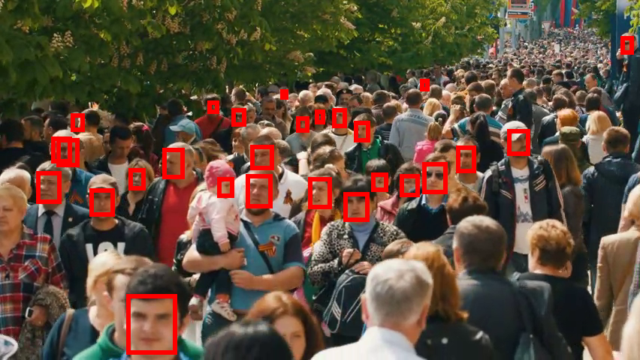

In [9]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass 

- `Сохранение видео` с детектированными лицами

In [10]:
import numpy as np
import cv2


video_tracked_path = db_path + 'video_tracked.mp4'

dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter(video_tracked_path, fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()

___
### <center><a id=4 >Дообучение модели</a>

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np

- Определение `папки с изображениями`
- Определение `параметров обучения`

In [1]:
import os
import torch

data_dir = 'data/test_images'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

- `Создание модели детекции` лиц MTCNN 

In [3]:
from facenet_pytorch import MTCNN

mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

- Создание объекта `dataset` с изображениями
- Создание объекта `DataLoader` с изображениями
- MTCNN `детектирует и обрезает лица`, результат помещается в новую папку

In [10]:
from facenet_pytorch import training
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]

loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Удаляем mtcnn для осовбождения памяти
del mtcnn

Batch 1 of 1

- Создание модели распознавания `InceptionResnetV1`, с предобученными весами


In [13]:
from facenet_pytorch import  InceptionResnetV1

resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

- Создание `алгоритма оптимизации` (Adam)
- Создание `настройщика скорости обучения` (MultiStepLR)
- Создание `цепочки преобразований` для объектов датасета (Compose):
    - приведение к типу np.float32
    - приведение к тензору
    - стандартизация изображения
- Создание `обучающего и тестового` объектов DataLoader


In [16]:
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization


optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

- Создание функции потерь (`CrossEntropyLoss`)
- Определение метрик

In [17]:

loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

- Создание объекта класса (`SummaryWriter`) записи данных для использования в TensorBoard 
- Дообучение модели `training.pass_epoch`

In [19]:
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()




Initial
----------
Valid |     1/1    | loss:    1.6447 | fps:    0.0055 | acc:    0.0000   

Epoch 1/8
----------
Train |     1/1    | loss:    1.5430 | fps:    5.4750 | acc:    0.2500   
Valid |     1/1    | loss:    1.9062 | fps:   14.4258 | acc:    0.0000   

Epoch 2/8
----------
Train |     1/1    | loss:    0.3145 | fps:    7.7908 | acc:    1.0000   
Valid |     1/1    | loss:    4.8227 | fps:   19.2344 | acc:    0.0000   

Epoch 3/8
----------
Train |     1/1    | loss:    0.0341 | fps:    7.6817 | acc:    1.0000   
Valid |     1/1    | loss:    7.1684 | fps:   16.5483 | acc:    0.0000   

Epoch 4/8
----------
Train |     1/1    | loss:    0.0070 | fps:    8.2763 | acc:    1.0000   
Valid |     1/1    | loss:    7.4439 | fps:   17.6062 | acc:    0.0000   

Epoch 5/8
----------
Train |     1/1    | loss:    0.0024 | fps:    6.3763 | acc:    1.0000   
Valid |     1/1    | loss:    6.6085 | fps:   17.1283 | acc:    0.0000   

Epoch 6/8
----------
Train |     1/1    | loss:    0.

___
## <center><a id=5>Анализ работы библиотеки</a>

___
### <center><a id=6>Датасет</a>
Для анализа работы библиотеки используется датасет [*Facescrub*](https://www.kaggle.com/search).  
Датасет состоит из 5982 изображений с  529 уникальными известными личностями. 

___
- `Создание датафрейма` :

    - `img_path` : путь к файлу
    - `class_name` : класс объекта

In [ ]:
import pandas as pd
import numpy as np
import os


db_path = 'data/Facescrub/'

def list_images(path):
    """Create default dict with img paths"""
    imgs_list = []
    for dir in os.listdir(path):
        full_path = os.path.join(path, dir)
        for img_name in os.listdir(full_path):
            img_path = os.path.join(full_path, img_name)         
            if img_path.endswith('.png') or img_path.endswith('.jpg') or img_path.endswith('.jpeg') :
                imgs_list.append((img_path, dir))

    return imgs_list

___
#### <<<<<<<< <a style='color:red'>Создание датафрейма исходных данных</a> >>>>>>>>
___

In [2]:
from sklearn.preprocessing import LabelEncoder


list_img = list_images(db_path)
df = pd.DataFrame(list_img, columns=['img_path', 'class_name'])
encoder = LabelEncoder()
labels = encoder.fit_transform(df['class_name'])
df = df.drop(columns='class_name')
df['labels'] = labels
df[:2]

,img_path,labels
0,data/Facescrub/Aaron_Eckhart\Aaron_Eckhart_105...,0
1,data/Facescrub/Aaron_Eckhart\Aaron_Eckhart_194...,0


- `Статистическая` информация о датасете:

In [3]:
grouped_df = df.groupby(['labels'])['labels'].agg('count')
print("Количество всего изображений:", df.shape[0])
print("Среднее количество изображений на одного человека:", int(grouped_df.mean()))
print("Минимальное количество изображений на одного человека:", int(grouped_df.min()))
print("Максимальное количество изображений на одного человека:", int(grouped_df.max()))
print("Количество уникальных людей:", int(grouped_df.shape[0]))

Количество всего изображений: 5982
Среднее количество изображений на одного человека: 11
Минимальное количество изображений на одного человека: 1
Максимальное количество изображений на одного человека: 29
Количество уникальных людей: 529


___
### <center><a id=7>Анализ функций</a>

Для анализа функций библиотеки использовались следующие метрики:

- `Embedding_time`: Время (сек.) детектирования лица и создания эмбединга для одного изображения

- `Macro_recall`: Усредненное значение recall для мультиклассовых задач:
    - Рассчитывается значение recall для каждого класса :
        - $\boxed{ \frac{TP}{TP + FN} }$
    - Рассчитывется среднее значение recall из всех классов:
        - $\boxed{ \frac{1}{n}\sum_{i=1}^n{(recall_{i})}}$

- `Macro_precision`: Усредненное значение precision для мультиклассовых задач:
    - Рассчитывается значение precision для каждого класса :
        - $\boxed{\frac{TP}{TP + FP}}$

    - Рассчитывется среднее значение precision из всех классов:
        - $\boxed{ \frac{1}{n}\sum_{i=1}^n{(precision_{i})}}$

- `Macro_f1`: Усредненное значение F1 для мультиклассовых задач:
    - Рассчитывается значение F1 для каждого класса :
        - $\boxed{\frac{2 \cdot Precision \cdot Recall}{Precision + Recall}}$

    - Рассчитывется среднее значение F1 из всех классов:
        - $\boxed{ \frac{1}{n}\sum_{i=1}^n{(F1{i})}}$

- `NaN_count`: Количество недетектированных лиц




___
- `Возвращение эмбедингов` facenet-pytorch:
    - df: Датафрейм
    - pretrained_weights: Веса предобученной модели
        - 'vggface2' 
        - 'casia-webface'

- `Создание столбцов с эмбедингами`

In [4]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image

def get_embedding_list(df: pd.DataFrame, model_params: dict) -> list:
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mtcnn = MTCNN()
    resnet = InceptionResnetV1(**model_params).eval()

######## After model init ##########
    emb_list = []
    obj_count = df.count().values[0]
    for obj_num in range(obj_count):
        try:
            img_path = df['img_path'][obj_num]
            img = Image.open(img_path)
            img_cropped = mtcnn(img)
            img_embedding = resnet(img_cropped.unsqueeze(0))
            emb_list.append(img_embedding.detach().numpy())
        except Exception:
            emb_list.append(np.nan)
    return emb_list
    
def get_embedding_column(df: pd.DataFrame, model_params: dict) -> pd.DataFrame:

    emb_list  = get_embedding_list(df, model_params)
    param_name = list(model_params.values())[0]
    df[param_name] = emb_list
    
    return df

___
#### <<<<<<<< <a style='color:red'>Создание столбца эмбеддингов</a> >>>>>>>>
___

In [11]:
df_example = df[:3]
model_params = {'pretrained': 'vggface2'}

df_example = get_embedding_column(df_example, model_params)
df_example

,img_path,labels,vggface2
0,data/Facescrub/Aaron_Eckhart\Aaron_Eckhart_105...,0,"[[0.05366709, -0.08842934, 0.0069119674, 0.028..."
1,data/Facescrub/Aaron_Eckhart\Aaron_Eckhart_194...,0,"[[0.0062582167, -0.11352147, -0.019524956, -0...."
2,data/Facescrub/Aaron_Eckhart\Aaron_Eckhart_274...,0,"[[0.00059679645, -0.10510773, -0.10683876, -0...."


- `Создание датасета с анализом модели`

___
### <center><a id=8>Сохранение промежуточных данных</a>

- `Создание датасета` с эмбедингами

In [ ]:
df_emb = df[:]

emb_parameter_list = ['vggface2', 'casia-webface']
for emb_parameter in emb_parameter_list:
    model_params = {'pretrained': emb_parameter}
    df_emb = get_embedding_column(df_emb, model_params)
df_emb = df_emb.dropna()
df_emb.reset_index(inplace=True,drop=True)

- `Экспорт` датафрейма в pkl-файл

In [13]:
import pickle


db_path = 'data/Analysis/'
df_name = 'df_embedded'
pickle.dump(df_emb, open(db_path + df_name + '.pkl', 'wb'))

- `Импорт` датафрейма из pkl-файла

In [6]:
import pickle


db_path = 'data/Analysis/'
df_name = 'df_embedded'

df_emb = pickle.load(open(db_path + df_name + '.pkl', 'rb'))
df_emb.head(1)

,img_path,labels,vggface2,casia-webface
0,data/Facescrub/Aaron_Eckhart\Aaron_Eckhart_105...,0,"[[0.05366709, -0.08842934, 0.0069119674, 0.028...","[[0.0038595798, 0.015715193, 0.0030699784, -0...."


- `Удаление объектов` класса количеством < 7

In [7]:
labels_arr = df_emb['labels'].values
for label in labels_arr:
    if df_emb[(df_emb['labels'] == label)]['labels'].count() < 7:
        df_emb.drop(labels=df_emb[(df_emb['labels'] == label)]['labels'].index, inplace=True)
df_emb['labels'].shape

(5437,)

- `Создание матрицы` из эмбеддингов

In [5]:
import numpy as np


def column_to_matrix(df: pd.DataFrame, column: str, array_size: int=512):
    col = df.loc[:, column]
    matrix = col.to_numpy()[0].reshape(array_size)
    for i in range(1, col.shape[0]):
        array = col.to_numpy()[i].reshape(array_size)
        matrix = np.vstack([matrix , array]) 
        
    return matrix

- `Экспорт` матрицы эмбеддингов в pkl-файл

In [42]:
X_casia = column_to_matrix(df_emb, 'casia-webface')

db_path = 'data/Analysis/'
df_name = 'Matrix_casia'

pickle.dump(X_casia, open(db_path + df_name + '.pkl', 'wb'))
X_casia.shape

(5437, 512)

- `Импорт` матрицы эмбеддингов из pkl-файла

In [44]:
db_path = 'data/Analysis/'
df_name = 'Matrix_vgg'

X_vgg = pickle.load(open(db_path + df_name + '.pkl', 'rb'))

db_path = 'data/Analysis/'
df_name = 'Matrix_casia'

X_casia = pickle.load(open(db_path + df_name + '.pkl', 'rb'))
X_casia.shape, X_vgg.shape

((5437, 512), (5437, 512))

___
### <center><a id=9>Датафрейм с результатами анализа</a>

Для каждой анализируемой функции библиотеки:
- Матрица эмбеддингов и массив целевых классов разбивалась при помощи метода `Stratified k-Fold` на 5 частей, где каждая часть содержит примерно такое же соотношение целевых классов, как и весь исходный массив целевых классов. Тем самым использовались все данные датасета для получения значений метрик.

- В качестве алгоритма предсказания класса выбран метод взвешанных k-ближайших соседей (`weighted KNN`), который отдает большее преимущество в выборе класса ближайшим "соседям"

- Для подбора оптимального количества "соседей" для получения наилучших метрик качества (recall, precision, F1) использовался метод `Grid SearchCV`


In [62]:
import time
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


def analysis_models( 
                    df: pd.DataFrame,
                    target_column: str,
                    model_params: dict, 
                    param_grid: dict, 
                    df_path: str='data/Analysis/Analysis_facenet.csv',
                    get_embedding:bool=False,
                    framework:str='Facenet-pytorch',
                    min_objects:int=7):
    
    param_name = list(model_params.values())[0]
    
######## Столбец с эмбеддингами ########
    emb_time = 0
    if get_embedding is True:
        start_time = time.time()
        df = get_embedding_column(df, model_params)
        end_time = time.time()
        emb_time = round((end_time - start_time) / df.shape[0], 2)
        nan_count = df[df[param_name].isna()]['img_path'].count()
    print(f'Эмбеддинги {model_params} добавлены в датафрейм > {time.strftime("%H : %M")}')
        
######## Удаление NaN ########
    befor_drop_size = df.shape[0]
    df = df.dropna()
    df.reset_index(inplace=True,drop=True)
    after_drop_size = df.shape[0]
    print(f'Удалено {befor_drop_size - after_drop_size} объектов NaN > {time.strftime("%H : %M")}')

######## Удаление объектов с минимальным кол-ом в классе ########
    labels_arr = df[target_column].values
    for label in labels_arr:
        if df[(df[target_column] == label)][target_column].count() < min_objects:
            df.drop(labels=df[(df[target_column] == label)][target_column].index, inplace=True)

######## Создание матрицы эмбеддингов ########
    X = column_to_matrix(df, param_name)
    y = df.loc[:, target_column].to_numpy()
    print(f'Размер X: {X.shape} размер y: {y.shape} > {time.strftime("%H : %M")}')

######## Подбор параметров ########
    knn = KNeighborsClassifier(n_jobs=-1, weights='distance')
    grid = GridSearchCV(estimator=knn, cv=5, param_grid=param_grid, scoring=['recall_macro', 'precision_macro', 'f1_macro'], refit=False, verbose=1)
    grid.fit(X, y)
    
    recall = grid.cv_results_['mean_test_recall_macro'].max()
    i = grid.cv_results_['mean_test_recall_macro'].argmax()
    knn_params_recall = grid.cv_results_['params'][i]

    precision = grid.cv_results_['mean_test_precision_macro'].max()
    i = grid.cv_results_['mean_test_precision_macro'].argmax()
    knn_params_precision = grid.cv_results_['params'][i]

    f1 = grid.cv_results_['mean_test_f1_macro'].max()
    i = grid.cv_results_['mean_test_f1_macro'].argmax()
    knn_params_f1 = grid.cv_results_['params'][i]
    
######## Создание датафрейма ########
    try:
        df_analysis = pd.read_csv(df_path)
        df_temp = pd.DataFrame(data={'Framework': [framework], 'Parameter': [param_name], 'Embedding_time' : [emb_time], 'Macro_recall' : [recall],  'Macro_precision' : [precision], 'Macro_f1' : [f1], 'KNN_params_recall': [knn_params_recall], 'KNN_params_precision': [knn_params_precision], 'KNN_params_f1': [knn_params_f1], 'NaN_count': [nan_count]} )
        df_analysis= pd.concat([df_analysis, df_temp])
        print(f'Данные добавлены в датафрейм {df_path} > {time.strftime("%H : %M")}\n','_'*50)
    except Exception:

        df_analysis = pd.DataFrame(data={'Framework': [framework], 'Parameter': [param_name], 'Embedding_time' : [emb_time], 'Macro_recall' : [recall],  'Macro_precision' : [precision], 'Macro_f1' : [f1], 'KNN_params_recall': [knn_params_recall], 'KNN_params_precision': [knn_params_precision], 'KNN_params_f1': [knn_params_f1], 'NaN_count': [nan_count]} )
        print(f'Создан датафрейм {df_path} > {time.strftime("%H : %M")}\n','_'*50)
    df_analysis.to_csv(df_path, index=False)
    

___
#### <<<<<<<< <a style='color:red'>Создание датафрейма с анализом</a> >>>>>>>>
___

In [ ]:
df_analysis = df[:100]

grid_params = {'n_neighbors': range(1, 7), 'metric': ['cosine', 'l2']}

model_params = {'pretrained': 'vggface2'}
analysis_models(df=df_analysis, target_column='labels',  model_params=model_params, param_grid=grid_params, get_embedding=True)

model_params = {'pretrained': 'casia-webface'}
analysis_models(df=df_analysis, target_column='labels',  model_params=model_params, param_grid=grid_params, get_embedding=True)

pd.read_csv('data/Analysis/Analysis_facenet.csv')

____
### [К содержанию](#100)
____
